In [0]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import time
import math
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MISC FUNCTIONS




In [0]:
def get_targets_tensor(file_path):
    return torch.from_numpy(np.loadtxt(file_path, dtype = np.float32)).to(device = device)

def load_dataset(dataset_paths):
    lst = []
    print('generating features for all video clips')
    for dataset_path in dataset_paths:
        video_clip = np.loadtxt(dataset_path[0], dtype = np.float32)
        feature_tensors = torch.from_numpy(video_clip).to(device = device)

        targets = get_targets_tensor(dataset_path[1])
        # TODO: make sure feature_tensors.device == cuda

        lst.append((feature_tensors, targets))
        print(len(lst))
    print('done generating features for all video clips', len(lst))
    return lst


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def get_dataset_path():
    #  TODO: Need to change this to load the actual dataset
    lst = []
    for _ in range(1, 86):
        video_path = f'drive/My Drive/dataset/train/videoclips/clip_' \
                     f'{_}/feature_tensors.txt'
        target_path = f'drive/My Drive/dataset/train/groundtruth/clip_{_}.txt'
        lst.append((video_path, target_path))
    return lst

## RNN MODEL DEFINITION

In [0]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_size + hidden_size, hidden_size)
        self.hidden_layer_1 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden)).to(device = device)
        x = self.input_layer(combined)
        hidden = self.hidden_layer_1(x)
        output = self.output_layer(hidden)
        sigmoid_op = self.sigmoid(output)
        return sigmoid_op, hidden

    def initHidden(self):
        return torch.zeros(self.hidden_size).to(device = device)

## TRAINING PART


In [0]:
# TODO: add Exponential loss, and move it to CUDA
def _train(video_sequence_tensor, true_value_tensor, rnn, criterion, optimizer):
    """
    This function scope is over a video clip,
    its supposed to get a video frame tensor generated using Genaret_feature
    :param true_value_tensor:
    :param video_sequence_tensor: [n, 4096], where n is the length of video
    sequence
    :return:
    """
    hidden = rnn.initHidden()
    optimizer.zero_grad()
    prediction_list = []
    current_loss = 0
    for i in range(video_sequence_tensor.size()[0]):
        prediction_tensor, hidden = rnn(video_sequence_tensor[i], hidden)
        prediction_list.append(prediction_tensor)
    # get prediction for every frame
    prediction_tensor = torch.cat(prediction_list).to(device = device)

    loss = criterion(prediction_tensor, true_value_tensor)
    # we want Exponential Loss here
    loss.backward()  # backpropogate

    optimizer.step()

    return loss.item()  # return  total loss for the current video sequence

In [0]:
def train(video_clip_target):

    rnn = RNN(4096, n_hidden).to(device = device)

    # TODO: Change this later to Exponential Loss
    criterion = nn.BCELoss()

    optimizer = optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    start = time.time()

    for epoch in range(1, epochs + 1):
        random.shuffle(video_clip_target)  # random the video clips (so the model does not
        # memorize anything
       
        for idx, data_item in enumerate(video_clip_target):
          
            feature_tensors = data_item[0]
            targets = data_item[1]
            
            loss = _train(feature_tensors, targets, rnn , criterion, optimizer)
            current_loss += loss

        all_losses.append(current_loss)
        print('epochs=', epoch, 'total Loss in this epoch=', current_loss,
              'time since start=', timeSince(start))
        current_loss = 0
        # Save the model
        torch.save(rnn.state_dict(), 'rnn_optimized' + str(
                epoch) +
                   '.model')

    plt.figure()
    plt.plot(all_losses)
    plt.show()
    plt.savefig('total_loss.png')

epochs= 1 total Loss in this epoch= 75.27200621366501 time since start= 0m 7s
epochs= 2 total Loss in this epoch= 57.176633179187775 time since start= 0m 15s
epochs= 3 total Loss in this epoch= 56.59160399436951 time since start= 0m 23s
epochs= 4 total Loss in this epoch= 55.69530254602432 time since start= 0m 31s
epochs= 5 total Loss in this epoch= 57.95298790931702 time since start= 0m 38s
epochs= 6 total Loss in this epoch= 55.68367460370064 time since start= 0m 46s
epochs= 7 total Loss in this epoch= 54.065049558877945 time since start= 0m 54s
epochs= 8 total Loss in this epoch= 54.56119254231453 time since start= 1m 2s
epochs= 9 total Loss in this epoch= 55.262395560741425 time since start= 1m 9s
epochs= 10 total Loss in this epoch= 54.27244991064072 time since start= 1m 17s
epochs= 11 total Loss in this epoch= 53.81199508905411 time since start= 1m 25s
epochs= 12 total Loss in this epoch= 54.62316390872002 time since start= 1m 33s
epochs= 13 total Loss in this epoch= 55.052665948

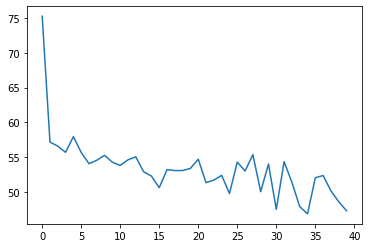

<Figure size 432x288 with 0 Axes>

In [191]:
n_hidden = 2048
epochs = 40
train(video_clip_target)

In [0]:
del dataset[83]
del video_clip_target[83]

In [0]:
dataset = get_dataset_path()
video_clip_target = load_dataset(dataset)
del dataset[28]
del video_clip_target[28]

## TESTING PART

In [0]:
def _test(video_sequence_tensor, rnn):
    """
    This function scope is over a video clip,
    its supposed to get a video frame tensor generated using Genaret_feature
    :param true_value_tensor:
    :param video_sequence_tensor: [n, 4096], where n is the length of video
    sequence
    :return:
    """
    hidden = rnn.initHidden()
    prediction_list = []
    for i in range(video_sequence_tensor.size()[0]):
        # for ith frame in the video frame
        prediction_tensor, hidden = rnn(video_sequence_tensor[i], hidden)
        prediction_list.append(prediction_tensor)
        # get prediction for every frame
    prediction_tensor = torch.cat(prediction_list)
    # get prediction for every frame


    return prediction_tensor.cpu().data.numpy()  # return  total loss for the current video sequence

In [0]:
def test(video_clip_target):
    scores = []
    rnn = RNN(4096, n_hidden).to(device=device)
    rnn.load_state_dict(torch.load(
            'rnn_optimized40.model'))
    rnn.eval()
    yhat = []
    y = []
    for data_item in video_clip_target:
        feature_tensors = data_item[0]
        targets = data_item[1].cpu().data.numpy().astype(int)
        # print(targets)
        output = _test(feature_tensors, rnn)
        scores.append(np.array(output))
        output[output >= 0.26] = 1
        output[output < 0.26] = 0
        output = output.astype(int)
        # print(output)
        # print('current clip accuracy = ', np.mean(output == targets))
        # print(classification_report(targets, output))
        yhat.append(output)
        y.append(targets)

    yhat = np.concatenate(yhat)
    y = np.concatenate(y)
    print(classification_report( y, yhat ))
    print(confusion_matrix(y, yhat))
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    print('tn = ', tn ,' fp= ', fp, 'fn = ',fn,' tp = ',tp)
    return scores, y

In [307]:
scores , true = test(video_clip_target)

              precision    recall  f1-score   support

           0       0.82      0.75      0.79      2804
           1       0.63      0.72      0.67      1660

    accuracy                           0.74      4464
   macro avg       0.73      0.74      0.73      4464
weighted avg       0.75      0.74      0.74      4464

[[2116  688]
 [ 466 1194]]
tn =  2116  fp=  688 fn =  466  tp =  1194


In [0]:
scores = np.concatenate(scores)

In [309]:
fpr, tpr, thresholds = metrics.roc_curve(true, scores)
roc_auc = metrics.auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

0.26103628


In [296]:
roc_auc

0.808284421566437

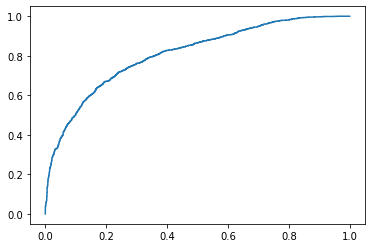

In [293]:
plt.plot(fpr, tpr)
plt.show()